This notebook demonstrates a method of using overlapping user interaction to extract relationship between different groups of products on an ecommerce site. The data for theis notebook can be found here https://www.kaggle.com/datasets/mkechinov/ecommerce-events-history-in-electronics-store

In [107]:
from itertools import combinations, permutations
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.cluster as cluster
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocessing

from scipy.cluster.hierarchy import dendrogram, linkage

In [108]:
# Load the data
data = pd.read_csv('./events.csv')

In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     885129 non-null  object 
 1   event_type     885129 non-null  object 
 2   product_id     885129 non-null  int64  
 3   category_id    885129 non-null  int64  
 4   category_code  648910 non-null  object 
 5   brand          672765 non-null  object 
 6   price          885129 non-null  float64
 7   user_id        885129 non-null  int64  
 8   user_session   884964 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 60.8+ MB


In [110]:
data.nunique()

event_time       845041
event_type            3
product_id        53453
category_id         718
category_code       107
brand               999
price             12422
user_id          407283
user_session     490398
dtype: int64

In [111]:
cats_by_user = data.groupby('user_id',as_index=False).agg({'category_id':'nunique'})
counts_of_users_with_num_cats = cats_by_user.groupby('category_id').agg({'user_id':'nunique'})
counts_of_users_with_num_cats

,user_id
category_id,
1,391139
2,12429
3,2208
4,683
5,351
6,174
7,102
8,67
9,48


As we can see, the vast majority of users visit exactly 1 category. This will make our job siginificantly harder, as we are not trying to build clusters from over 800,000 user visits. We are actually trying to do it from 15k. However, before we drop single category visits, let's calculate the probablity of a category being visited by a user.

In [112]:
single_category_probability = data.groupby('category_id').agg({'user_id':'nunique'})/data['user_id'].nunique()
single_category_probability.head(10)

,user_id
category_id,
2144415921001726020,0.005934
2144415921085612102,0.001191
2144415921169498184,0.031197
2144415921203052617,0.001530
2144415921253384266,0.002836
2144415921303715915,0.001002
2144415921337270348,0.003324
2144415921379213389,0.000385
2144415921421156430,0.001903


In [113]:
right_users = cats_by_user.loc[cats_by_user['category_id'] > 1, 'user_id'].to_list()
filt_data = data.loc[data['user_id'].isin(right_users),:]

What we do next is interesting. We want to compute hierachial clusters to understand relatedness. To do this, we need some sort of distance metric. Often, something like a Jaccard index is used. Jaccard index have the convenient property of being symetric, but they can understimate the relatedness of groups of different sizes. For example, if group A has 1000 members and group B has 10 members, the Jaccard index can be no more than 10/1000. This may be much lower than the Jaccard index between group A and another group, event though the case where group A completely covers group B would indicate a strong relationship.

To circumvent this problem, we can use a different metric, also symetric, derived from Baye's Theorem. A slightly rewritten version of Baye's Theorem is

$$\frac{P(A|B)}{P(A)} = \frac{P(B|A)}{P(B)}$$

Furthermore, we can use the definition of coditional probabilities to expand both sides to show that what we are in fact measuring is the degree of dependence of the two variables

$$\frac{\frac{P(A\cap B)}{P(B)}}{P(A)} = \frac{\frac{P(A\cap B)}{P(A)}}{P(B)} = \frac{P(A\cap B)}{P(A)P(B)}$$

So, by using the probablities of the events, we can calculate a symetric metric that avoids the Jaccard index's weakness to class imbalance. The metric is not immediately suitable to clustering, but can be transformed to be so.

In [114]:
# Use the information in filtdata to calculate the probability of any pair of categories being viewed by the same user.
user_categories = filt_data.groupby('user_id')['category_id'].apply(list)
    
# Step 2: Create a Counter object to store pair counts
pair_counts = Counter()

# Step 3: For each user, generate pairs of category ids and update the counter
for categories in user_categories:
    for cat1, cat2 in permutations(sorted(set(categories)), 2):  # Use set to avoid duplicate pairs from the same user
        pair_counts[(cat1, cat2)] += 1

# Convert the Counter object to a DataFrame
pair_df = pd.DataFrame(list(pair_counts.items()), columns=['category_pair', 'count'])
pair_df[['category_id1', 'category_id2']] = pd.DataFrame(pair_df['category_pair'].tolist(), index=pair_df.index)
pair_df.drop(columns=['category_pair'], inplace=True)

pair_df = pair_df[['category_id1', 'category_id2', 'count']]
pair_df.head(10)


,category_id1,category_id2,count
0,2144415923107266682,2144415924424278172,9
1,2144415924424278172,2144415923107266682,9
2,2144415921169498184,2144415924684325027,16
3,2144415921169498184,2144415925196030129,68
4,2144415924684325027,2144415921169498184,16
5,2144415924684325027,2144415925196030129,42
6,2144415925196030129,2144415921169498184,68
7,2144415925196030129,2144415924684325027,42
8,2144415921001726020,2144415926848585945,11
9,2144415921001726020,2144415929943982381,5


Now that we have unique counts, we can convert to probabilities and get our desired coefficient

In [115]:
pair_df['count_one'] = pair_df['category_id1'].map(lambda x: single_category_probability.loc[x,'user_id']) * data['user_id'].nunique()
pair_df['count_two'] = pair_df['category_id2'].map(lambda x: single_category_probability.loc[x,'user_id']) * data['user_id'].nunique()
pair_df['probability_both'] = pair_df['count'] / data['user_id'].nunique()
pair_df['probability_independent'] = pair_df['category_id1'].map(lambda x: single_category_probability.loc[x,'user_id']) * pair_df['category_id2'].map(lambda y: single_category_probability.loc[y,'user_id'])
pair_df['expected_count'] = pair_df['probability_independent'] * data['user_id'].nunique()
pair_df['coefficient'] = pair_df['probability_both'] / pair_df['probability_independent']
pair_df.sort_values('coefficient', ascending=False, inplace=True)
pair_df.head(30)

,category_id1,category_id2,count,count_one,count_two,probability_both,probability_independent,expected_count,coefficient
8633,2144415934574494123,2144415934549328298,2,4.0,5.0,0.000005,1.205695e-10,0.000049,40728.300000
8631,2144415934549328298,2144415934574494123,2,5.0,4.0,0.000005,1.205695e-10,0.000049,40728.300000
14994,2144415934457053607,2144415932737388916,1,9.0,2.0,0.000002,1.085125e-10,0.000044,22626.833333
14991,2144415932737388916,2144415934457053607,1,2.0,9.0,0.000002,1.085125e-10,0.000044,22626.833333
15334,2144415932284404071,2144415966728028473,1,10.0,2.0,0.000002,1.205695e-10,0.000049,20364.150000
15365,2144415966728028473,2144415932284404071,1,2.0,10.0,0.000002,1.205695e-10,0.000049,20364.150000
10425,2144415931697201499,2144415931655258458,1,2.0,11.0,0.000002,1.326264e-10,0.000054,18512.863636
10416,2144415931655258458,2144415931697201499,1,11.0,2.0,0.000002,1.326264e-10,0.000054,18512.863636
14992,2144415933936959894,2144415932737388916,1,12.0,2.0,0.000002,1.446834e-10,0.000059,16970.125000
14990,2144415932737388916,2144415933936959894,1,2.0,12.0,0.000002,1.446834e-10,0.000059,16970.125000


In [116]:
#len(pair_df[pair_df['count'] > 1])
filt_pair_df = pair_df.loc[(pair_df['expected_count'] > 15)|(pair_df['count'] > 15),:]
filt_pair_df.head(50)

,category_id1,category_id2,count,count_one,count_two,probability_both,probability_independent,expected_count,coefficient
4492,2144415942350733951,2144415958851125332,20,1764.0,98.0,0.000049,0.000001,0.424452,47.119603
4493,2144415958851125332,2144415942350733951,20,98.0,1764.0,0.000049,0.000001,0.424452,47.119603
1596,2144415923535085701,2144415973346640379,201,3196.0,1475.0,0.000494,0.000028,11.574507,17.365750
1598,2144415973346640379,2144415923535085701,201,1475.0,3196.0,0.000494,0.000028,11.574507,17.365750
827,2144415935698567627,2144415935732122060,36,978.0,897.0,0.000088,0.000005,2.153947,16.713503
837,2144415935732122060,2144415935698567627,36,897.0,978.0,0.000088,0.000005,2.153947,16.713503
378,2144415973346640379,2144415922167742561,83,1475.0,1496.0,0.000204,0.000013,5.417854,15.319718
375,2144415922167742561,2144415973346640379,83,1496.0,1475.0,0.000204,0.000013,5.417854,15.319718
1530,2144415927318348006,2144415927351902439,20,712.0,781.0,0.000049,0.000003,1.365321,14.648571
1537,2144415927351902439,2144415927318348006,20,781.0,712.0,0.000049,0.000003,1.365321,14.648571


Now we transform the coefficient into something useful for clustering

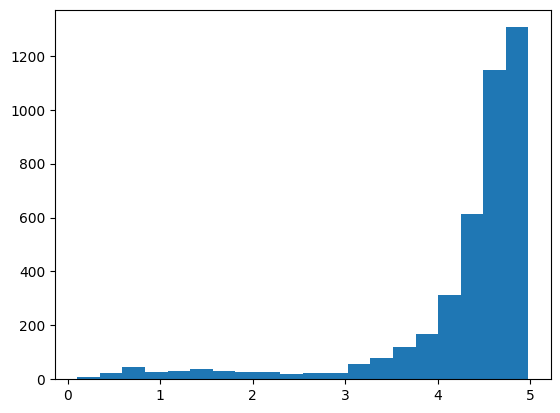

In [122]:
filt_pair_df.loc[:,'transformed_coefficient'] = 5/(1+np.power(filt_pair_df['coefficient'],1))
_ = plt.hist(filt_pair_df['transformed_coefficient'], bins=20)

We can see that our "distance" is heavy on the far apart, even prior to filling NA

In [118]:
dists = concatenated_df.pivot(index='category_id1', columns='category_id2', values='transformed_coefficient').fillna(4)
for cat in dists.columns:
    dists.loc[cat,cat] = 0
dists.shape

(240, 240)

In [119]:
ac = cluster.AgglomerativeClustering(n_clusters=None, distance_threshold=0, metric='precomputed', linkage='average', compute_distances=True)
ac.fit(dists)

AgglomerativeClustering(compute_distances=True, distance_threshold=0,
                        linkage='average', metric='precomputed',
                        n_clusters=None)

(239, 4)


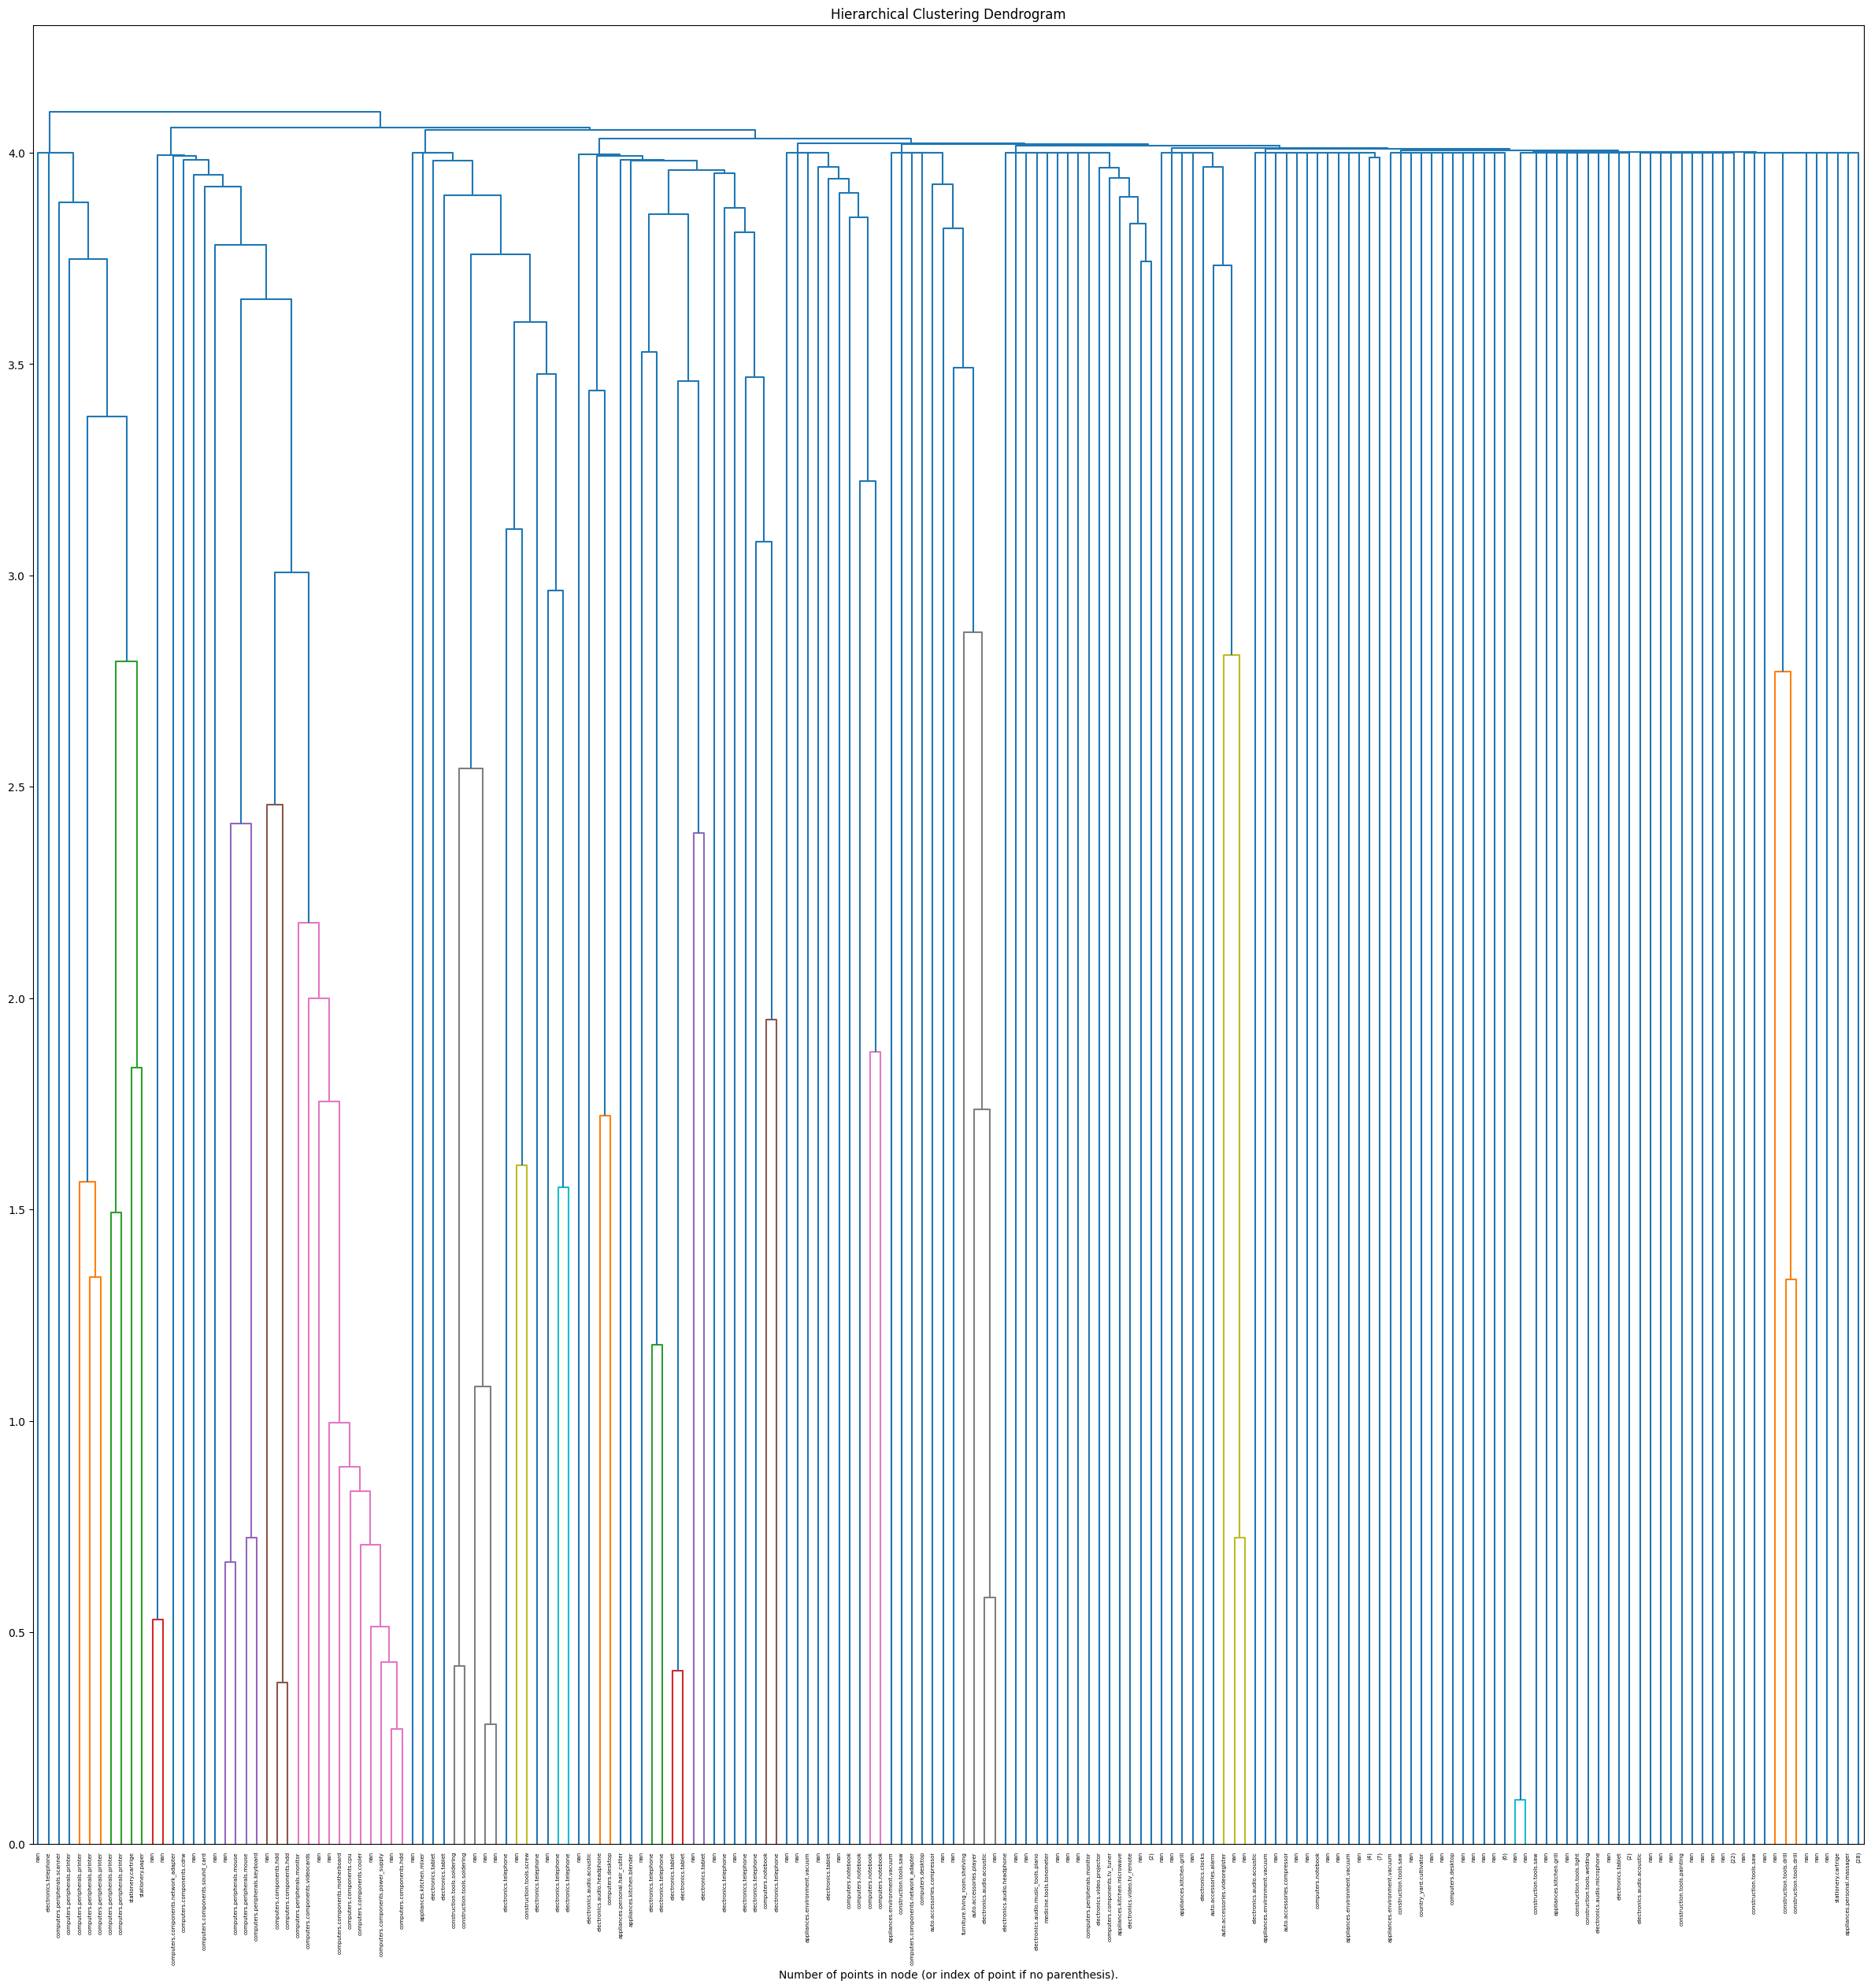

In [120]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    print(linkage_matrix.shape)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# write code that converts the category_id to the category name, or to the category_id if the name is not available
result_dict = data.set_index('category_id')['category_code'].to_dict()
def id_to_name(id):
    return result_dict.get(id, id)


plt.figure(figsize=(30, 30), dpi=100)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(ac, truncate_mode="level", p=20, labels=dists.index.map(id_to_name), count_sort=True)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()